# Chaotic inflation example: 2 fields

We will demonstrate how to install, and sample over the single field quadratic example:
\begin{equation}
    V(\phi, \theta) = \frac{1}{2} m_\phi^2 \phi^2 + \frac{1}{2} m_\theta^2 \theta^2
\end{equation}

In [1]:
import os
import numpy as np
import sympy as sym
import pandas as pd
import matplotlib.pyplot as plt
from pytsa.pytrans_setup import Translator
from pytsa.sampler import setup_sampler

from plot_kde import plot_kde  # Helper script for plotting KDEs

-- MPI import successful


## Part 1: Model installion

In [3]:
# Number of params. We just have the mass parameter for the potential.
n_pars = 2

# Number of fields. We just have the field \phi.
n_fields = 2

# Define symbolic arrays containing parameters and fields
pars = sym.symarray("p", n_pars)
fields = sym.symarray("f", n_fields)

# Construct potential. Note how we use the "sym.Rational" method, to construct rational fractions.
# This isn't strictly required, but is good practice when performing symbolic calculations in SymPy,
# as it aids with simplifications.
potential = sym.Rational(1, 2) * pars[0] ** 2 * fields[0] ** 2 + sym.Rational(1, 2) * pars[1] ** 2 * fields[1] ** 2

In [4]:
potential

f_0**2*p_0**2/2 + f_1**2*p_1**2/2

In [5]:
pars_nc = sym.symarray("p", n_pars + 1)
metric = sym.Matrix([[pars_nc[2] ** 2, 0], [0, pars_nc[2] ** 2 * sym.sin(fields[0]) ** 2]]) 
metric

Matrix([
[p_2**2,                  0],
[     0, p_2**2*sin(f_0)**2]])

In [6]:
Translator(n_fields, n_pars, potential, simplify_metric=True, simplify_potential=True, simplify_covd=True, verbose=True)

try:
    from pytsa.models import double_chaotic
except ImportError:
    Translator.install("double_chaotic")
    from pytsa.models import double_chaotic

-- Derived covariant derivatives loaded from cache
-- Derived covariant derivatives loaded from cache
-- Repacking potentials into flat arrays
   [Thu Aug 25 12:09:29 2022] writing to potential.h
   [Thu Aug 25 12:09:29 2022] performing CSE for V
   [Thu Aug 25 12:09:29 2022] complete in 0.00046424999999938876 sec
   [Thu Aug 25 12:09:29 2022] performing CSE for dV
   [Thu Aug 25 12:09:29 2022] complete in 0.0004539919999997366 sec
   [Thu Aug 25 12:09:29 2022] performing CSE for ddV
   [Thu Aug 25 12:09:29 2022] complete in 0.00023337699999981254 sec
   [Thu Aug 25 12:09:29 2022] performing CSE for dddV
   [Thu Aug 25 12:09:29 2022] complete in 0.00042404800000017673 sec
   [Thu Aug 25 12:09:29 2022] complete in 0.013305489999999587 sec


In [7]:
Translator(n_fields, n_pars + 1, potential, simplify_metric=True, simplify_potential=True, simplify_covd=True, verbose=True, G=metric)

try:
    from pytsa.models import double_chaotic_nc
except ImportError:
    Translator.install("double_chaotic_nc")
    from pytsa.models import double_chaotic_nc

-- Derived covariant derivatives loaded from cache
-- Translating field space symbols
-- Repacking curvature quantities into flat arrays
   [Thu Aug 25 12:09:29 2022] performing CSE for field metric
   [Thu Aug 25 12:09:29 2022] complete in 0.001698631000000006 sec
   [Thu Aug 25 12:09:29 2022] performing CSE for Christoffel symbols
   [Thu Aug 25 12:09:29 2022] complete in 0.0014076709999999437 sec
   [Thu Aug 25 12:09:29 2022] performing CSE for Riemann tensor
   [Thu Aug 25 12:09:29 2022] complete in 0.0022308000000004213 sec
   [Thu Aug 25 12:09:29 2022] performing CSE for Riemann tensor
   [Thu Aug 25 12:09:29 2022] complete in 0.008128248000000227 sec
-- Derived covariant derivatives loaded from cache
-- Repacking potentials into flat arrays
   [Thu Aug 25 12:09:29 2022] writing to potential.h
   [Thu Aug 25 12:09:29 2022] performing CSE for V
   [Thu Aug 25 12:09:29 2022] complete in 0.0005288530000004954 sec
   [Thu Aug 25 12:09:29 2022] performing CSE for dV
   [Thu Aug 25 12:

## Sampling

We set up samplers for the double quadratic potential model with a canonical Euclidean fieldspace metric, and with a non-canonical 2-sphere metric

In [8]:
# Initialize sampler object
setup = setup_sampler.SamplerMethods(
    double_chaotic,
    "double_field_example",
    cache_loc=os.path.join(os.getcwd(), "sample_data")  # defaults to ./samplers
)

# Initialize sampler object
setup_nc = setup_sampler.SamplerMethods(
    double_chaotic_nc,
    "double_field_nc_example",
    cache_loc=os.path.join(os.getcwd(), "sample_data")  # defaults to ./samplers
)

We will sample the field ics from the following distribution functions:

$f_0 = \phi \sim \mathrm{Unif}(-100, 100)$

$f_1 = \theta \sim \mathrm{Unif}(-100, 100)$

$\dot{f_0} = \dot{\phi} \sim \mathcal{N}(0, 10^{-3})$

$\dot{f_1} = -\frac{\partial V}{\partial f_1} \frac{1}{\sqrt{3 V}}$ (Slow-roll equation)

$\ln p_1 = \ln m_\phi = \mathrm{Unif}(\ln 10^{-6}, \ln 10^{-3})$

$\ln p_2 = \ln m_\theta = \mathrm{Unif}(\ln 10^{-6}, \ln 10^{-3})$

The radial scale ($R$) in the 2-sphere metric is sampled over:

$p_2 = R \sim \mathrm{Unif}(0, 10)$,

which effectively varies the Ricci-Curvature $\mathrm{Ric} = 2/R^2$.

In [9]:
from scipy.stats import uniform, norm, loguniform

# Setup analysis hyper parameters, if not set will use defaults at build
for s in [setup, setup_nc]:

    s.set_analysis_params(
        N_sub_evo=3,      # defaults to 6
        N_adiabatic=1,    # defaults to 1
        step_density=8,   # defaults to 20
        tols=[1e-4, 1e-4],# defaults = [1e-8, 1e-8]
        tmax_bg=2,
        tmax_2pf=5,
        tmax_3pf=10
    )
    
    # Set priors on initial field values
    s.set_field(
        0, 1,                      # specify which fields the definition corresponds to
        method=uniform(-100, 200)  # define the prior
    )

    # Set priors on initial field velocty values
    s.set_dot_field(
        0,                    # same as above
        method=norm(0, 1e-3)  # same as above, except, can pass "sr" to use slow-roll equation
    )

    s.set_dot_field(
        1,                    # same as above
        method="sr"           # same as above, except, can pass "sr" to use slow-roll equation
    )

    # Set priors on parameter values (analogous to field definitions)
    s.set_param(
        0, 1,
        method=loguniform(1e-6, 1e-2)  
    )

setup_nc.set_param(2, method=uniform(0, 10))
    
# build sampler
setup.build_sampler()
setup_nc.build_sampler()

In [10]:
exec_path = os.path.join(setup.cache_loc, "run.py")
exec_nc_path = os.path.join(setup_nc.cache_loc, "run.py")

latin_sampler_nc_name = latin_sampler_name = "ex_latin"

In [11]:
# Should take a few minutes (serial via NB)
os.system(f"python {exec_path} {latin_sampler_name} --n_samples 500 --latin --ns --entropy 1234")

-- MPI import successful

-- Computing background trajectories


-- Background complete.


-- Computing epsilon data


-- Epsilon complete.


-- Computing eta data


-- Eta complete.


-- Computing mass data


-- Masses complete.


-- Computing observables


-- Observables complete.

Writing results
All done.


0

In [12]:
# Should take 5-10 minutes (serial via NB)
os.system(f"python {exec_nc_path} {latin_sampler_nc_name} --n_samples 500 --latin --ns --entropy 1234 --verbose")

-- MPI import successful

-- Computing background trajectories


-- Background complete.


-- Computing epsilon data


-- Epsilon complete.


-- Computing eta data


-- Eta complete.


-- Computing mass data


-- Masses complete.


-- Computing observables


-- Observables complete.

Writing results
All done.


0

In [13]:
data_path = os.path.join(setup.cache_loc, latin_sampler_name, f"pandas_{latin_sampler_name}.df")
data_path_nc = os.path.join(setup_nc.cache_loc, latin_sampler_nc_name, f"pandas_{latin_sampler_nc_name}.df")

In [14]:
data = pd.read_pickle(data_path)
data_nc = pd.read_pickle(data_path_nc)

In [15]:
data.columns

Index(['f_0', 'f_1', 'v_0', 'v_1', 'p_0', 'p_1', 'eps_exit', 'eps_end',
       'eta_exit', 'eta_end', 'm_exit_0', 'm_exit_1', 'm_end_0', 'm_end_1',
       'ns', 'running', 'As'],
      dtype='object')

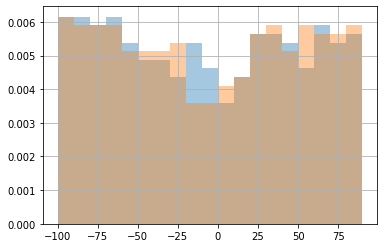

In [16]:
plt.hist(data['f_0'], bins=np.arange(-100, 100, 10), density=True, alpha=0.4)
plt.hist(data['f_1'], bins=np.arange(-100, 100, 10), density=True, alpha=0.4)
plt.grid()

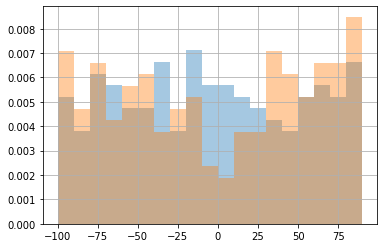

In [17]:
plt.hist(data_nc['f_0'], bins=np.arange(-100, 100, 10), density=True, alpha=0.4)
plt.hist(data_nc['f_1'], bins=np.arange(-100, 100, 10), density=True, alpha=0.4)
plt.grid()

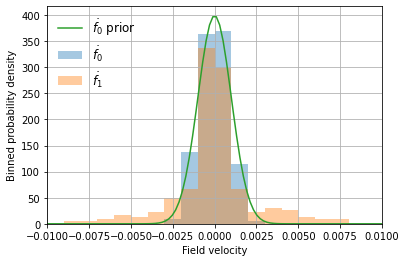

In [18]:
plt.hist(data_nc['v_0'], bins=np.arange(-0.009, 0.009, 0.001), density=True, alpha=0.4, label=r"$\dot{f_0}$")
plt.hist(data_nc['v_1'], bins=np.arange(-0.009, 0.009, 0.001), density=True, alpha=0.4, label=r"$\dot{f_1}$")

x = np.linspace(-0.01, 0.01, 100)

plt.plot(x, norm(0, 1e-3).pdf(x), label=r"$\dot{f_0}$ prior")

plt.legend(frameon=False, loc="upper left", fontsize=12)

plt.xlim(-0.01, 0.01)

plt.xlabel("Field velocity")
plt.ylabel("Binned probability density")

plt.grid()

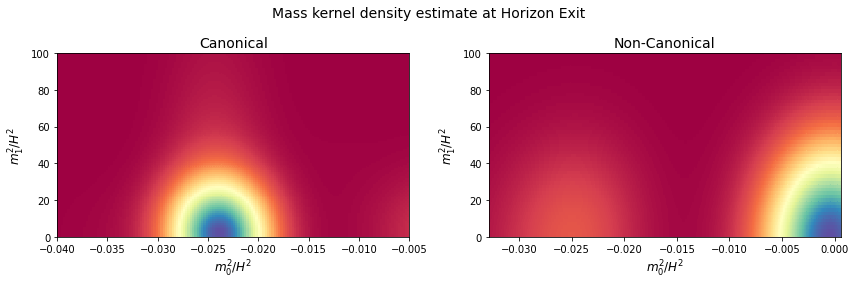

In [19]:
fig, (ax, ax_nc) = plt.subplots(1, 2, figsize=(12, 4))

plot_kde(data, "m_exit_0", "m_exit_1", ax=ax)
plot_kde(data_nc, "m_exit_0", "m_exit_1", ax=ax_nc)

for a in (ax, ax_nc):
    a.set_ylim(0, 100)
    
ax.set_xlim(-0.04, -0.005)

for ax, title in zip([ax, ax_nc], ['Canonical', 'Non-Canonical']):
    ax.set_title(title, size=14)
    ax.set_xlabel(r"$m_0^2/H^2$", size=12)
    ax.set_ylabel(r"$m_1^2/H^2$", size=12)
    
plt.suptitle(r"Mass kernel density estimate at Horizon Exit", size=14)
plt.tight_layout()

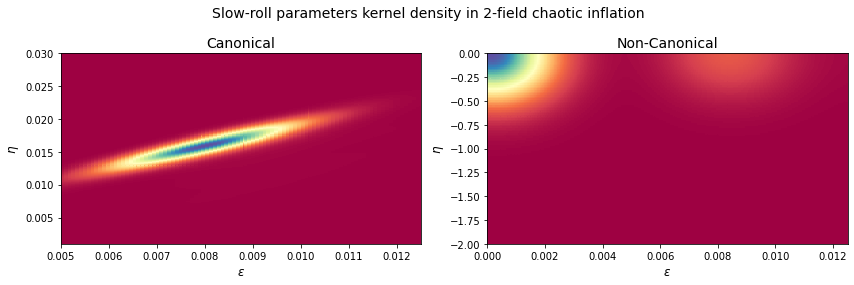

In [20]:
fig, (ax, ax_nc) = plt.subplots(1, 2, figsize=(12, 4))

plot_kde(data, "eps_exit", "eta_exit", ax=ax)
plot_kde(data_nc, "eps_exit", "eta_exit", ax=ax_nc)

# for a in (ax, ax_nc):
#     a.set_ylim(0, 100)
    
ax.set_xlim(0.005, 0.0125)
ax_nc.set_xlim(0, 0.0125)

ax.set_ylim(0.001, 0.03)
ax_nc.set_ylim(-2, 0)

for ax, title in zip([ax, ax_nc], ['Canonical', 'Non-Canonical']):
    ax.set_title(title, size=14)
    ax.set_xlabel(r"$\epsilon$", size=12)
    ax.set_ylabel(r"$\eta$", size=12)
    
plt.suptitle(r"Slow-roll parameters kernel density in 2-field chaotic inflation", size=14)
plt.tight_layout()

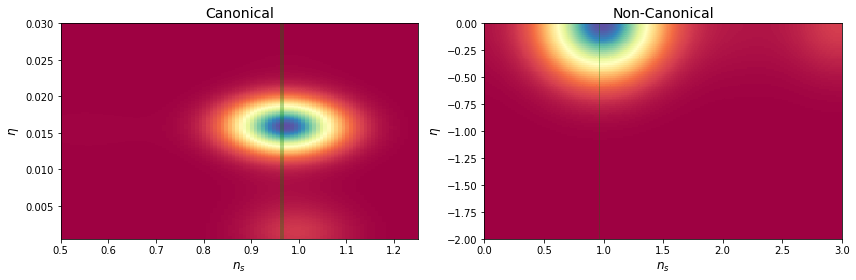

In [21]:
fig, (ax, ax_nc) = plt.subplots(1, 2, figsize=(12, 4))

plot_kde(data, "ns", "eta_exit", ax=ax)
plot_kde(data_nc, "ns", "eta_exit", ax=ax_nc)
    
ax.set_xlim(0.5, 1.25)
ax_nc.set_xlim(0, 3)

ax.set_ylim(0.0005, 0.03)
ax_nc.set_ylim(-2, 0)

for a, title in zip([ax, ax_nc], ['Canonical', 'Non-Canonical']):
    a.set_title(title, size=14)
    a.set_xlabel(r"$n_s$", size=12)
    a.set_ylabel(r"$\eta$", size=12)
    a.axvspan(0.9649-0.0042, 0.9649+0.0042, facecolor="g", alpha=0.3)
    
# plt.suptitle(r"Slow-roll parameters kernel density in 2-field chaotic inflation", size=14)
plt.tight_layout()